# Book Recommendation System

## Content

1. About Dataset
2. Libraries and Utilities
3. Preprocessing
4. Item-Based Collaborative Filtering
5. Content-Based Collaborative Filtering using *Title, Author, Publisher, Category* as features
6. Content-Based Collaborative Filtering using *Summary* as a feature
7. Custom Recommender
8. Comparison of All Recommenders

# About Dataset

Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

# Install Library

In [412]:
%pip install pandas
%pip install matplotlib
%pip install requests
%pip install scikit-learn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Libraries and Utilities

In [413]:
import os
import re
import requests
import warnings
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
nltk.download('corpus')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading corpus: Package 'corpus' not found in index
[nltk_data] Downloading package punkt to /home/minhchien/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/minhchien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load and Check Data

In [414]:
books = pd.read_csv('data_train/preprocessed_data.csv')
books.head(3)

,user_id,rating,book_title,author,publisher,imgs,desc,category
0,550,5,Assistant to the Villain,Hannah Nicole Maehrer,"Entangled Publishing, LLC",{'https://prodimage.images-bn.com/lf?set=key%5...,"This book ticks a great many boxes—humor, horr...","['Comic Fantasy', 'Fantasy Romance', 'Science ..."
1,204,5,Assistant to the Villain,Hannah Nicole Maehrer,"Entangled Publishing, LLC",{'https://prodimage.images-bn.com/lf?set=key%5...,"This book ticks a great many boxes—humor, horr...","['Comic Fantasy', 'Fantasy Romance', 'Science ..."
2,445,5,Assistant to the Villain,Hannah Nicole Maehrer,"Entangled Publishing, LLC",{'https://prodimage.images-bn.com/lf?set=key%5...,"This book ticks a great many boxes—humor, horr...","['Comic Fantasy', 'Fantasy Romance', 'Science ..."


# Preprocessing

In [415]:
df = books.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.drop(index=df[df['category'] == '9'].index, inplace=True) #remove 9 in category

df.drop(index=df[df['rating'] == 0].index, inplace=True) #remove 0 in rating

df['category'] = df['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

df['book_title'] = [book.replace('"',"") for book in df['book_title'].values]

df.head(2)

,user_id,rating,book_title,author,publisher,imgs,desc,category
0,550,5,Assistant to the Villain,Hannah Nicole Maehrer,"Entangled Publishing, LLC",{'https://prodimage.images-bn.com/lf?set=key%5...,"This book ticks a great many boxes—humor, horr...",Comic Fantasy Fantasy Romance Science Fiction ...
1,204,5,Assistant to the Villain,Hannah Nicole Maehrer,"Entangled Publishing, LLC",{'https://prodimage.images-bn.com/lf?set=key%5...,"This book ticks a great many boxes—humor, horr...",Comic Fantasy Fantasy Romance Science Fiction ...


# Item-Based Collaborative Filtering

In [416]:
def item_based_recommender(book_title):
    
    book_title = str(book_title).replace('"',"")
    if book_title in df['book_title'].values:
        data =df['book_title'].value_counts()
        rating_counts = pd.DataFrame(data)
        rare_books = rating_counts[rating_counts.values <= 3].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:    
            random = pd.Series(common_books['book_title'].unique()).sample(16).values
            print('There are no recommendations for this book')
            print('Try: \n')
            for book in random:
                print('{}'.format(book),'\n')
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'],
                                                    values='rating')

            book = user_book_df[book_title]
            recom_data = pd.DataFrame(user_book_df.corrwith(book).
                                    sort_values(ascending=False)).reset_index(drop=False)
            
            # remove book_title in rcm_data
            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
            
            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 3:
                    low_rating.append(i)
                    
            # filter book low rating if count of book rcm > 16
            if recom_data.shape[0] - len(low_rating) > 16:
                recom_data = recom_data[~recom_data.index.isin(low_rating)]
            
            recom_data = recom_data[0:16]
            recom_data.columns = ['id','corr']
            
            print(recom_data)
    else:
        print('Cant find book in dataset, please check spelling')

In [417]:
item_based_recommender('Assistant to the Villain')

/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                                                   id  corr
0                          A Bakery in Paris: A Novel   NaN
1                                A Beautiful Disguise   NaN
2   A Beautiful Rival: A Novel of Helena Rubinstei...   NaN
3                            A Charming Doorstep Baby   NaN
4    A Conjuring of Light (Shades of Magic Series #3)   NaN
5        A Dark and Stormy Tea (Tea Shop Mystery #24)   NaN
6                              A Death in Door County   NaN
7   A Dish to Die For: A Key West Food Critic Mystery   NaN
8                          A Duet with the Siren Duke   NaN
9                                      A Fatal Affair   NaN
10          A Fatal Groove: The Record Shop Mysteries   NaN
11                                   A Fatal Illusion   NaN
12                           A Fire at the Exhibition   NaN
13                     A Game of Gods (Hades Saga #3)   NaN
14                    A Killer in the Family: A Novel   NaN
15                 A Lady's Guide to Sca

In [418]:
item_based_recommender('23 1/2 Lies')

There are no recommendations for this book
Try: 

The First Binding 

Encore in Death: An Eve Dallas Novel (In Death Series #56) 

Our Crooked Hearts: A Novel 

The Hurricane Blonde 

Wyoming Cowboy Undercover 

Aristotle and Dante Discover the Secrets of the Universe 

The Truth About Horses: A Novel 

Lessons 

The Sun and the Void 

Playing For Keeps 

The Honeys 

Start Us Up: A Park Avenue Promise Novel 

The Bride of Lycaster 

The Rebel King 

Harm's Way 

The Orphan Duck 



In [419]:
item_based_recommender('Godkiller: A Novel')

/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                   id  corr
1                          A Bakery in Paris: A Novel   NaN
2                                A Beautiful Disguise   NaN
3   A Beautiful Rival: A Novel of Helena Rubinstei...   NaN
4                            A Charming Doorstep Baby   NaN
5    A Conjuring of Light (Shades of Magic Series #3)   NaN
6        A Dark and Stormy Tea (Tea Shop Mystery #24)   NaN
7                              A Death in Door County   NaN
8   A Dish to Die For: A Key West Food Critic Mystery   NaN
9                          A Duet with the Siren Duke   NaN
10                                     A Fatal Affair   NaN
11          A Fatal Groove: The Record Shop Mysteries   NaN
12                                   A Fatal Illusion   NaN
13                           A Fire at the Exhibition   NaN
14                     A Game of Gods (Hades Saga #3)   NaN
15                    A Killer in the Family: A Novel   NaN
16                 A Lady's Guide to Sca

# Content-Based Collaborative Filtering

## Title, Author, Publisher, Category

In [420]:
def content_based_recommender(book_title):
    
    book_title = str(book_title).replace('"',"")
    if book_title in df['book_title'].values:
        data =df['book_title'].value_counts()
        rating_counts = pd.DataFrame(data)
        rare_books = rating_counts[rating_counts.values <= 0].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(16).values
            print('There are no recommendations for this book')
            print('Try: \n')
            for book in random:
                print('{}'.format(book),'\n')
        
        else:
            
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title','author','publisher','category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:17]
            
            books = []
            for i in range(len(sorted_sim_books)):
                book_cor = [common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item(),sorted_sim_books[i][1]]
                books.append(book_cor)
            
            print(books)
    else:
        
        print('Cant find book in dataset, please check spelling')

In [421]:
content_based_recommender('Assistant to the Villain')

[['The Stars are Dying: Nytefall Book 1', 0.761904761904762], ['Make Her: A Dark Beauty and the Beast Fantasy Romance', 0.7561334445873297], ['Only Good Enemies: A Galactic Bonds Book', 0.7235318156129492], ['Of Stars and Tides', 0.7151332219343157], ['Soul Taken', 0.6988459044322258], ['Of Deathless Shadows', 0.6595501762613933], ['Son of the Drowned Empire', 0.6570510502689109], ['The First Binding', 0.6250541102117805], ['The Phoenix King', 0.6249773956129332], ['The Gloom Between Stars', 0.6172133998483675], ['Be the Serpent', 0.6113149794833975], ['Godkiller: A Novel', 0.6097013950210626], ['Nona the Ninth', 0.6072576922212718], ['The Jasad Heir', 0.6060915267313266], ['The Midnight Kingdom', 0.6060915267313266], ['Thistlefoot: A Novel', 0.600099198148979]]


In [422]:
content_based_recommender('My Roommate Is a Vampire')

[['Mixed Signals', 0.7845986714489122], ['Sweetwater and the Witch', 0.7698512161427535], ['The Seven Year Slip', 0.7614922044449459], ['Thrive (Addicted Series #6)', 0.7529932885360187], ['You, with a View', 0.7477945020767084], ['With Love, from Cold World', 0.7433046224826585], ['Magnolia Parks', 0.7321141582036941], ['Business or Pleasure', 0.7313574508612275], ['Holiday Rebel: An Albertini Family Romance #3:', 0.7284227860260539], ['Addicted After All (Addicted Series #7)', 0.7195100006612606], ['Unbreak my Heart: A Steamy Second Chance Romance', 0.7190233885442832], ['The Love Plot', 0.7152816976385906], ['Moving Forward', 0.7152816976385906], ['A Shot in the Dark: A Novel', 0.7126907593011393], ['Perfect Fling', 0.706138804304021], ['Curves for Days', 0.706138804304021]]


In [423]:
content_based_recommender('23 1/2 Lies')

[['Long Shadows', 0.8400000000000002], ['Fear No Evil (Alex Cross Series #27)', 0.7794228634059948], ['The Cabinet of Dr. Leng', 0.7462185372015078], ['The Hurricane Blonde', 0.7452413135250994], ['Stay Awake: A Novel', 0.731310340973526], ['The Twyford Code', 0.7200000000000001], ['Righteous Prey', 0.709929573971954], ['Forsaken Country', 0.7060180864974626], ['Three Assassins: A Novel', 0.6666666666666667], ['Reckoning (FBI Series #26)', 0.6666666666666666], ['The Enigma of Room 622: A Novel', 0.6640783086353597], ['Cold, Cold Bones (Temperance Brennan Series #21)', 0.6259807120445899], ['The Devil Takes You Home: A Novel', 0.6099942813304187], ['Maidens of the Cave: A Novel', 0.5269651864139677], ['When These Mountains Burn', 0.5217758139277826], ['Suspect', 0.5196152422706632]]


## Summary

In [424]:
def content_based_recommender2(book_title):
    
    book_title = str(book_title).replace('"',"")
    if book_title in df['book_title'].values:
        data =df['book_title'].value_counts()
        rating_counts = pd.DataFrame(data)
        rare_books = rating_counts[rating_counts.values <= 3].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            
            summary_filtered = []
            for i in common_books['desc']:    
                i = re.sub("[^a-zA-Z]"," ",i).lower()
                i = nltk.word_tokenize(i)
                i = [word for word in i if word not in set(stopwords.words("english"))]
                i = " ".join(i)
                summary_filtered.append(i)
            
            common_books['desc'] = summary_filtered   
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['desc'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:17]
            
            books = []
            for i in range(len(sorted_sim_books)):
                book_cor = [common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item(),sorted_sim_books[i][1]]
                books.append(book_cor)
            
            print(books)
    else:
        print('Cant find book in dataset, please check spelling')

In [425]:
# content_based_recommender2('Assistant to the Villain')

In [426]:
# content_based_recommender2('My Roommate Is a Vampire')

In [427]:
# content_based_recommender2('23 1/2 Lies')

# Custom Recommender

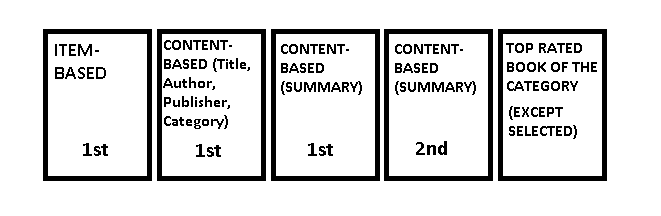

In [449]:
def custom_recommender(book_title):
    
    #ITEM-BASED
    book_title = str(book_title).replace('"',"")
    if book_title in df['book_title'].values:
    
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts.values <= 0].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            # user_book_df = common_books.pivot_table(index=['user_id'],
            #                                         columns=['book_title'], values='rating')
        
            # book = user_book_df[book_title]  
            # recom_data = pd.DataFrame(user_book_df.corrwith(book). \
            #                           sort_values(ascending=False)).reset_index(drop=False)
            
            # if book_title in [book for book in recom_data['book_title']]:
            #     recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
                
            # low_rating = []
            # for i in recom_data['book_title']:
            #     if df[df['book_title'] == i]['rating'].mean() < 3:
            #         low_rating.append(i)
                    
            # if recom_data.shape[0] - len(low_rating) > 16:
            #     recom_data = recom_data[~recom_data['book_title'].isin(low_rating)]
            
            # recom_data = recom_data[0:16]    
            # recom_data.columns = ['book_title','corr']
            recommended_books = []
            # for i in recom_data['book_title']:
            #     recommended_books.append(i)
                
            # df_new = df[~df['book_title'].isin(recommended_books)]
            df_new = df
            
            #CONTENT-BASED (Title, Author, Publisher, Category)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
        
            rare_books = rating_counts[rating_counts.values <= 0].index
    
            common_books = df_new[~df_new['book_title'].isin(rare_books)]
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]   
            target_cols = ['book_title','author','publisher','category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:17]
            
            books = []
            for i in range(len(sorted_sim_books)):
                book_cor = [common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item(),sorted_sim_books[i][1]]
                books.append(book_cor)
                
            for i in books:
                recommended_books.append(i)
            
            df_new = df_new[~df_new['book_title'].isin(recommended_books)]
            
            #CONTENT-BASED (SUMMARY)
            # rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
            # rare_books = rating_counts[rating_counts.values <= 3].index
            # common_books = df_new[~df_new['book_title'].isin(rare_books)]
            
            # common_books = common_books.drop_duplicates(subset=['book_title'])
            # common_books.reset_index(inplace= True)
            # common_books['index'] = [i for i in range(common_books.shape[0])]
            
            # summary_filtered = []
            # for i in common_books['desc']:
                
            #     i = re.sub("[^a-zA-Z]"," ",i).lower()
            #     i = nltk.word_tokenize(i)
            #     i = [word for word in i if not word in set(stopwords.words("english"))]
            #     i = " ".join(i)
            #     summary_filtered.append(i)
            
            # common_books['desc'] = summary_filtered
            # cv = CountVectorizer()
            # count_matrix = cv.fit_transform(common_books['desc'])
            # cosine_sim = cosine_similarity(count_matrix) 
            # index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            # sim_books = list(enumerate(cosine_sim[index]))
            # sorted_sim_books2 = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:4]
            # sorted_sim_books = sorted_sim_books2[1:17]
            # summary_books = []
            # for i in range(len(sorted_sim_books)):
            #     book_cor = [common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item(),sorted_sim_books[i][1]]
            #     summary_books.append(book_cor)
                
            # for i in summary_books:
            #     recommended_books.append(i)
                
            # df_new = df_new[~df_new['book_title'].isin(recommended_books)]
            
            #TOP RATED OF CATEGORY
            category = common_books[common_books['book_title'] == book_title]['category'].values[0]
            top_rated = common_books[common_books['category'] == category].groupby('book_title').agg({'rating':'mean'}).reset_index()
            
            if top_rated.shape[0] == 1:
                recommended_books.append(common_books[common_books['index'] == sorted_sim_books[2][0]]['book_title'].item())
                
            else:
                top_rated.drop(top_rated[top_rated['book_title'] == book_title].index[0],inplace=True)
                top_rated = top_rated.sort_values('rating',ascending=False).iloc[:1]['book_title'].values[0]
                recommended_books.append(top_rated)
                
            print(recommended_books[:16])
    else:
        print('Cant find book in dataset, please check spelling')

In [429]:
custom_recommender('Assistant to the Villain')

[['The Stars are Dying: Nytefall Book 1', 0.761904761904762], ['Make Her: A Dark Beauty and the Beast Fantasy Romance', 0.7561334445873297], ['Of Stars and Tides', 0.7151332219343157], ['Soul Taken', 0.6988459044322258], ['Of Deathless Shadows', 0.6595501762613933], ['Son of the Drowned Empire', 0.6570510502689109], ['The First Binding', 0.6250541102117805], ['The Phoenix King', 0.6249773956129332], ['The Gloom Between Stars', 0.6172133998483675], ['Godkiller: A Novel', 0.6097013950210626], ['The Jasad Heir', 0.6060915267313266], ['The Midnight Kingdom', 0.6060915267313266], ['Thistlefoot: A Novel', 0.600099198148979], ["Assassin's Apprentice", 0.5916079783099616], ['Royal Assassin', 0.5916079783099616], ["Assassin's Quest", 0.5916079783099616], 'Of Stars and Tides']


In [430]:
custom_recommender('My Roommate Is a Vampire')

[['Mixed Signals', 0.7845986714489122], ['Sweetwater and the Witch', 0.7698512161427535], ['The Seven Year Slip', 0.7614922044449459], ['Thrive (Addicted Series #6)', 0.7529932885360187], ['You, with a View', 0.7477945020767084], ['With Love, from Cold World', 0.7433046224826585], ['Magnolia Parks', 0.7321141582036941], ['Business or Pleasure', 0.7313574508612275], ['Addicted After All (Addicted Series #7)', 0.7195100006612606], ['Unbreak my Heart: A Steamy Second Chance Romance', 0.7190233885442832], ['The Love Plot', 0.7152816976385906], ['Moving Forward', 0.7152816976385906], ['A Shot in the Dark: A Novel', 0.7126907593011393], ['Perfect Fling', 0.706138804304021], ['Curves for Days', 0.706138804304021], ['Kissing Kosher: A Novel', 0.6960575579871306], 'The Seven Year Slip']


In [431]:
custom_recommender("23 1/2 Lies")

There are no recommendations for this book
Try: 

Mine To Promise 

Pestilence 



# Comparison of All Recommenders

In [432]:
item_based_recommender('Assistant to the Villain')

/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/minhchien/projects/rcm_data_book/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                                                   id  corr
0                          A Bakery in Paris: A Novel   NaN
1                                A Beautiful Disguise   NaN
2   A Beautiful Rival: A Novel of Helena Rubinstei...   NaN
3                            A Charming Doorstep Baby   NaN
4    A Conjuring of Light (Shades of Magic Series #3)   NaN
5        A Dark and Stormy Tea (Tea Shop Mystery #24)   NaN
6                              A Death in Door County   NaN
7   A Dish to Die For: A Key West Food Critic Mystery   NaN
8                          A Duet with the Siren Duke   NaN
9                                      A Fatal Affair   NaN
10          A Fatal Groove: The Record Shop Mysteries   NaN
11                                   A Fatal Illusion   NaN
12                           A Fire at the Exhibition   NaN
13                     A Game of Gods (Hades Saga #3)   NaN
14                    A Killer in the Family: A Novel   NaN
15                 A Lady's Guide to Sca

In [452]:
content_based_recommender('Assistant to the Villain')

[['The Stars are Dying: Nytefall Book 1', 0.761904761904762], ['Make Her: A Dark Beauty and the Beast Fantasy Romance', 0.7561334445873297], ['Only Good Enemies: A Galactic Bonds Book', 0.7235318156129492], ['Of Stars and Tides', 0.7151332219343157], ['Soul Taken', 0.6988459044322258], ['Of Deathless Shadows', 0.6595501762613933], ['Son of the Drowned Empire', 0.6570510502689109], ['The First Binding', 0.6250541102117805], ['The Phoenix King', 0.6249773956129332], ['The Gloom Between Stars', 0.6172133998483675], ['Be the Serpent', 0.6113149794833975], ['Godkiller: A Novel', 0.6097013950210626], ['Nona the Ninth', 0.6072576922212718], ['The Jasad Heir', 0.6060915267313266], ['The Midnight Kingdom', 0.6060915267313266], ['Thistlefoot: A Novel', 0.600099198148979]]


In [434]:
# content_based_recommender2('Assistant to the Villain')

In [451]:
custom_recommender('Assistant to the Villain')

[['The Stars are Dying: Nytefall Book 1', 0.761904761904762], ['Make Her: A Dark Beauty and the Beast Fantasy Romance', 0.7561334445873297], ['Only Good Enemies: A Galactic Bonds Book', 0.7235318156129492], ['Of Stars and Tides', 0.7151332219343157], ['Soul Taken', 0.6988459044322258], ['Of Deathless Shadows', 0.6595501762613933], ['Son of the Drowned Empire', 0.6570510502689109], ['The First Binding', 0.6250541102117805], ['The Phoenix King', 0.6249773956129332], ['The Gloom Between Stars', 0.6172133998483675], ['Be the Serpent', 0.6113149794833975], ['Godkiller: A Novel', 0.6097013950210626], ['Nona the Ninth', 0.6072576922212718], ['The Jasad Heir', 0.6060915267313266], ['The Midnight Kingdom', 0.6060915267313266], ['Thistlefoot: A Novel', 0.600099198148979]]


**Let's try another book**

In [436]:
item_based_recommender('"Solo Leveling, Vol. 7 (comic)"')

There are no recommendations for this book
Try: 

Role Playing 

The Sweetest Revenge 

The Prince and the Apocalypse 

The Patron Saint of Liars: A Novel 

The Marvellers 

The Perfect Wife 

Off the Grid 

A Dish to Die For: A Key West Food Critic Mystery 

The Last Masterpiece: A Novel of World War II Italy 

Don't Forget the Girl: A Novel 

The Husband List 

The Paris Mystery: A Novel 

Appointment in Bath 

Dead of Winter 

Need Me (Broke and Beautiful Series #2) 

The Shards of Ophelia 



In [448]:
content_based_recommender('"Solo Leveling, Vol. 7 (comic)"')

[["Can't Stop Cursing You, Vol. 4", 0.7816317493509031], ['Toilet-bound Hanako-kun, Vol. 18', 0.7804925426732848], ['The Summer Hikaru Died, Vol. 1', 0.750366479376867], ['Killing Stalking: Deluxe Edition Vol. 3', 0.7156264473321344], ['Solo Leveling, Vol. 8 (novel)', 0.7109714025666358], ['Goodbye, Eri', 0.6788335930269978], ['Tokyo Revengers (Omnibus) Vol. 11-12', 0.6636648415023737], ['Disney Twisted-Wonderland, Vol. 1: The Manga: Book of Heartslabyul', 0.6400104492354921], ['Stars of Chaos: Sha Po Lang (Novel) Vol. 1', 0.4700463948895648], ['Guardian: Zhen Hun (Novel) Vol. 1', 0.46932631293069804], ['Picture Day: (A Graphic Novel)', 0.2154101092138323], ['Hooky Volume 3', 0.17407765595569785], ['Lights', 0.16943474841747155], ['Silver Under Nightfall', 0.14519080172812557], ['Assistant to the Villain', 0.1343038273375634], ['The Stars are Dying: Nytefall Book 1', 0.1343038273375634]]


In [438]:
# content_based_recommender2('One Piece, Vol. 103')

In [450]:
custom_recommender('"Solo Leveling, Vol. 7 (comic)"')

[["Can't Stop Cursing You, Vol. 4", 0.7816317493509031], ['Toilet-bound Hanako-kun, Vol. 18', 0.7804925426732848], ['The Summer Hikaru Died, Vol. 1', 0.750366479376867], ['Killing Stalking: Deluxe Edition Vol. 3', 0.7156264473321344], ['Solo Leveling, Vol. 8 (novel)', 0.7109714025666358], ['Goodbye, Eri', 0.6788335930269978], ['Tokyo Revengers (Omnibus) Vol. 11-12', 0.6636648415023737], ['Disney Twisted-Wonderland, Vol. 1: The Manga: Book of Heartslabyul', 0.6400104492354921], ['Stars of Chaos: Sha Po Lang (Novel) Vol. 1', 0.4700463948895648], ['Guardian: Zhen Hun (Novel) Vol. 1', 0.46932631293069804], ['Picture Day: (A Graphic Novel)', 0.2154101092138323], ['Hooky Volume 3', 0.17407765595569785], ['Lights', 0.16943474841747155], ['Silver Under Nightfall', 0.14519080172812557], ['Assistant to the Villain', 0.1343038273375634], ['The Stars are Dying: Nytefall Book 1', 0.1343038273375634]]


**If you liked this notebook, please upvote** 😊

**If you have any suggestions or questions, feel free to comment!**

**Best Wishes!**